In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#load data
london_cycling = pd.read_excel('tfl-daily-cycle-hires.xlsx','Data')
nyc_cycling = pd.read_csv('citibike_daily_counts_2020.csv')

## London Data
Source:https://data.london.gov.uk/dataset/number-bicycle-hires

In [3]:
london_cycling.shape

(3839, 11)

In [4]:
london_cycling.head()

,Day,Number of Bicycle Hires,Unnamed: 2,Month,Number of Bicycle Hires.1,Unnamed: 5,Year,Number of Bicycle Hires.2,Unnamed: 8,Month.1,Average Hire Time (mins)
0,2010-07-30,6897,NaN,2010-07-01,12461.0,NaN,2010,2180813,NaN,2010-07-01,17.232566
1,2010-07-31,5564,NaN,2010-08-01,341203.0,NaN,2011,7142449,NaN,2010-08-01,16.551880
2,2010-08-01,4303,NaN,2010-09-01,540859.0,NaN,2012,9519283,NaN,2010-09-01,15.219079
3,2010-08-02,6642,NaN,2010-10-01,544412.0,NaN,2013,8045459,NaN,2010-10-01,15.204481
4,2010-08-03,7966,NaN,2010-11-01,456304.0,NaN,2014,10023897,NaN,2010-11-01,13.776083


In [5]:
#only take columns one and two (day and # of bike hires)
london_cycling_daily = london_cycling[['Day','Number of Bicycle Hires']]
london_cycling_daily = london_cycling_daily.rename(columns={"Number of Bicycle Hires": "daily_hires_london"})
#make df for 2020 data to compare to NYC data 
london_cycling_daily2020 = london_cycling_daily[london_cycling_daily['Day'].isin(pd.date_range('2019-12-31', '2021-01-01'))]
len(london_cycling_daily2020)

368

Text(0, 0.5, 'Daily Cycle Hires')

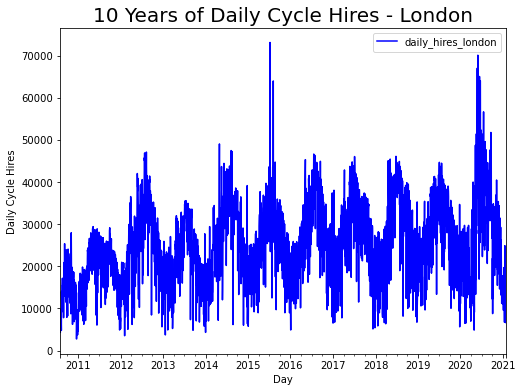

In [6]:
london_cycling_daily_plot = london_cycling_daily.set_index('Day')
london_cycling_daily_plot.plot(color='blue', figsize=(8, 6))
plt.title('10 Years of Daily Cycle Hires - London', fontsize=20)
plt.ylabel('Daily Cycle Hires')

In [7]:
#check for trend
(london_cycling_daily_plot.loc['2021-01-31']-london_cycling_daily_plot.loc['2010-07-30'])/30

daily_hires_london    327.766667
dtype: float64

In [8]:
#check top ridership days
london_cycling_daily_plot = london_cycling_daily_plot.sort_values(by=['daily_hires_london'], ascending = False)
Top20_london = london_cycling_daily_plot.head(20)
Top20_london.head()

,daily_hires_london
Day,
2015-07-09,73094
2020-05-30,70074
2020-05-25,67000
2020-06-13,65022
2020-06-20,64022


In [9]:
#check bottom ridership days
Bottom20_london = london_cycling_daily_plot.sort_values(by=['daily_hires_london'], ascending = True)
Bottom20_london = Bottom20_london.head(20)
Bottom20_london.head()

,daily_hires_london
Day,
2010-12-19,2764
2010-12-18,2805
2012-02-05,3531
2013-01-20,3728
2010-12-28,3763


In [10]:
#percentage of top 20 daily hire days over the past 10 years that were during 2020
len(Top20_london.loc[(Top20_london.index>'2019-12-31')])/len(Top20_london)

0.85

In [11]:
london_cycling_daily = london_cycling_daily.set_index('Day')
london_cycling_daily.head()

,daily_hires_london
Day,
2010-07-30,6897
2010-07-31,5564
2010-08-01,4303
2010-08-02,6642
2010-08-03,7966


Overall positive trend but it does depends on the end points. However, interesting to note that in the past 10 years, the day with the most daily hires was during 2020. 

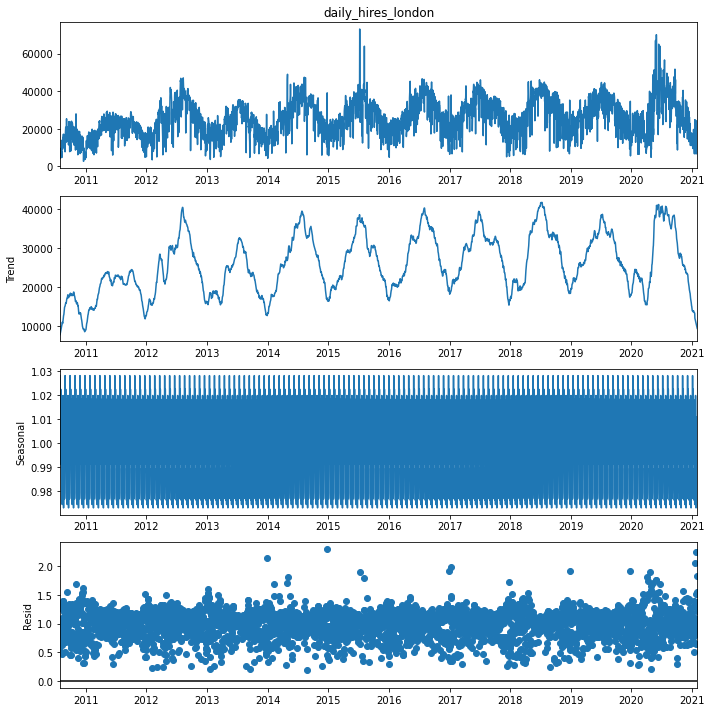

In [12]:
#a bit more scientific version of this is doing the daily decomposition
matplotlib.rcParams['figure.figsize'] = [10, 10]
dailyDecomp = seasonal_decompose(london_cycling_daily['daily_hires_london'], model='multiplicative', freq = 30, extrapolate_trend='freq')
fig = dailyDecomp.plot()

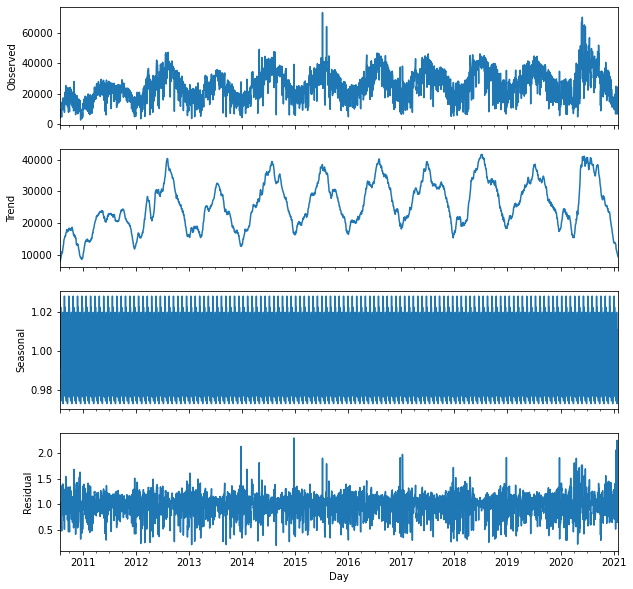

In [13]:
# redo seasonal decomposition to fix residual scatter plot
#same as above
fig, axes = plt.subplots(4, 1, sharex=True)
dailyDecomp.observed.plot(ax=axes[0], legend=False)
dailyDecomp.trend.plot(ax=axes[1], legend=False)
dailyDecomp.seasonal.plot(ax=axes[2], legend=False)
dailyDecomp.resid.plot(ax=axes[3], legend=False)

axes[0].set_ylabel('Observed')
axes[1].set_ylabel('Trend')
axes[2].set_ylabel('Seasonal')
axes[3].set_ylabel('Residual')

plt.show()

In [14]:
daySeries = london_cycling_daily['daily_hires_london']
dailyDecomp = seasonal_decompose(daySeries, model='additive', freq = 30, extrapolate_trend='freq')
residualMult = np.array(dailyDecomp.resid)
#fig = dailyDecomp.plot();

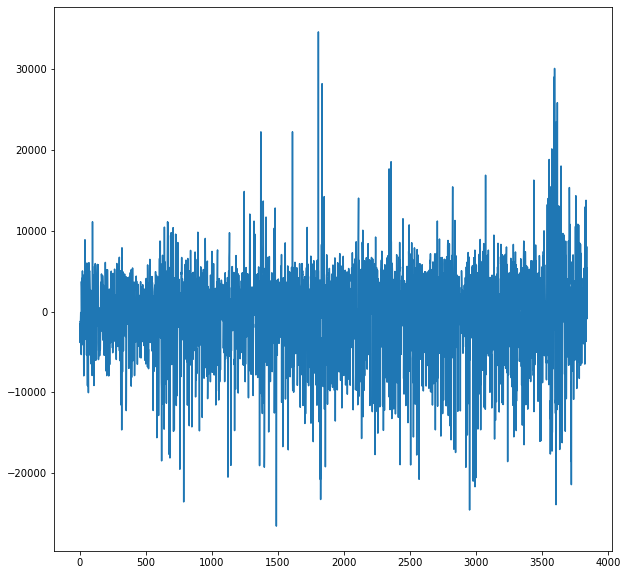

In [15]:
# normalize residual by log-transform
#logResid = np.log(dailyDecomp.resid/daySeries.values)
plt.plot(residualMult)

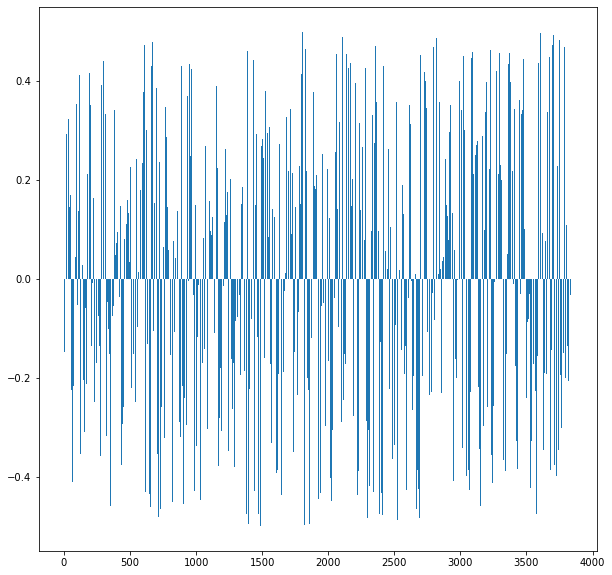

In [16]:
# based on percentile rank
outlierData = pd.DataFrame({})
outlierData['Res'] = residualMult
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'])
plt.show()

In [17]:
# There is no certain definition of outliers, common methods include percentile, standard deviation, and IQR.
# In this case, we select 1% outliers.
london_topPercentiles = london_cycling_daily.index[outlierData['Percentile_rank']>0.49]
london_topPercentiles = pd.DataFrame(london_topPercentiles)
london_topPercentiles.head(20)

,Day
0,2013-12-25
1,2014-04-29
2,2014-04-30
3,2014-05-18
4,2014-12-25
5,2015-07-09
6,2015-08-06
7,2015-08-22
8,2016-05-07
9,2016-05-08


In [18]:
#calculating # of days in 2020 in the top 1 percentile of ridership days
round((len(london_topPercentiles.loc[(london_topPercentiles['Day'] > '2019-12-31')])/len(london_topPercentiles))*100,1)

59.0

59% of the top 1 percentile of days in terms of daily hires in London over a ten year span were during 2020. 

In [19]:
#bottom 1 percentile of ridership days
london_BottomPercentiles = london_cycling_daily.index[outlierData['Percentile_rank']<-0.49]
london_BottomPercentiles = pd.DataFrame(london_BottomPercentiles)
london_BottomPercentiles.head()

,Day
0,2012-04-09
1,2012-06-03
2,2012-06-11
3,2012-08-25
4,2012-09-23


In [20]:
#calculating # of days in 2020 in the bottom 1 percentile of ridership days
round((len(london_BottomPercentiles.loc[(london_BottomPercentiles['Day'] > '2019-12-31')])/len(london_BottomPercentiles))*100,1)

18.4

18% of the bottom 1 percentile of days in terms of daily hires in London over a ten year span were during 2020. 

## NYC Data
Source: https://qri.cloud/nyc-transit-data/citibike_daily_counts_2020

In [21]:
nyc_cycling.head()

,date,station_id,startcount,endcount,station_name,station_longitude,station_latitude
0,2020-01-01,72,39.0,32.0,W 52 St & 11 Ave,-73.993929,40.767272
1,2020-01-01,79,15.0,15.0,Franklin St & W Broadway,-74.006667,40.719116
2,2020-01-01,82,16.0,17.0,St James Pl & Pearl St,-74.000165,40.711174
3,2020-01-01,83,16.0,18.0,Atlantic Ave & Fort Greene Pl,-73.976323,40.683826
4,2020-01-01,116,70.0,52.0,W 17 St & 8 Ave,-74.001497,40.741776


In [22]:
nyc_cycling['date'].min(),nyc_cycling['date'].max() #only til Nov
#if we want more data with demographics, available here https://s3.amazonaws.com/tripdata/index.html

('2020-01-01', '2020-10-31')

In [23]:
#group by day to get daily counts
nyc_cycling_daily2020 = nyc_cycling.groupby('date', as_index=False)['startcount'].sum()
nyc_cycling_daily2020 = nyc_cycling_daily2020.rename(columns={"startcount": "daily_cycling_nyc"})
nyc_cycling_daily2020.head()

,date,daily_cycling_nyc
0,2020-01-01,18114.0
1,2020-01-02,41556.0
2,2020-01-03,31873.0
3,2020-01-04,29436.0
4,2020-01-05,27589.0


Text(0, 0.5, 'Daily Cycle Hires')

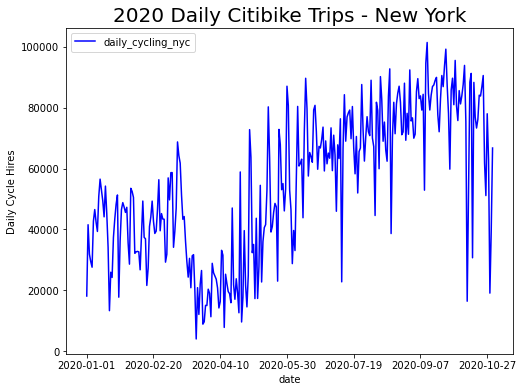

In [24]:
nyc_cycling_daily2020_plot = nyc_cycling_daily2020.set_index('date')
nyc_cycling_daily2020_plot.plot(color='blue', figsize=(8, 6))
plt.title('2020 Daily Citibike Trips - New York', fontsize=20)
plt.ylabel('Daily Cycle Hires') #check matches up with this graph here using same dataset: https://medium.com/qri-io/building-a-daily-aggregate-dataset-from-raw-citibike-trip-data-2b6502009871

In [25]:
#make sure both dates are the same dtypes for merge
london_cycling_daily2020.dtypes
nyc_cycling_daily2020.dtypes
nyc_cycling_daily2020['date'] = pd.to_datetime(nyc_cycling_daily2020['date'])

## Compare NYC & London

In [26]:
#merge London and NYC based on day
compare_cycling = london_cycling_daily2020.merge(nyc_cycling_daily2020, left_on='Day', right_on='date')
compare_cycling = compare_cycling[['Day','daily_hires_london','daily_cycling_nyc']]
compare_cycling.head()

,Day,daily_hires_london,daily_cycling_nyc
0,2020-01-01,11141,18114.0
1,2020-01-02,18675,41556.0
2,2020-01-03,18434,31873.0
3,2020-01-04,15695,29436.0
4,2020-01-05,12977,27589.0


In [27]:
#check range of dates
compare_cycling.Day.min(),compare_cycling.Day.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2020-10-31 00:00:00'))

In [28]:
#compare basic stats for first ten months of 2020
compare_cycling.describe()

,daily_hires_london,daily_cycling_nyc
count,305.000000,305.000000
mean,29773.895082,54692.537705
std,11961.109793,23930.644933
min,4871.000000,3999.000000
25%,21481.000000,35078.000000
50%,28679.000000,55071.000000
75%,38295.000000,75665.000000
max,70074.000000,101462.000000


In [29]:
(54693/29774) # daily nyc average ridership for 2020 is 1.8x that of London

1.836938268287768

In [30]:
#Check with current population counts
#NYC:https://worldpopulationreview.com/us-cities/new-york-city-ny-population
#London:https://worldpopulationreview.com/world-cities/london-population
print((54692/8230290)*100)
print((29774/9425622)*100)

0.6645209342562656
0.3158836626378609


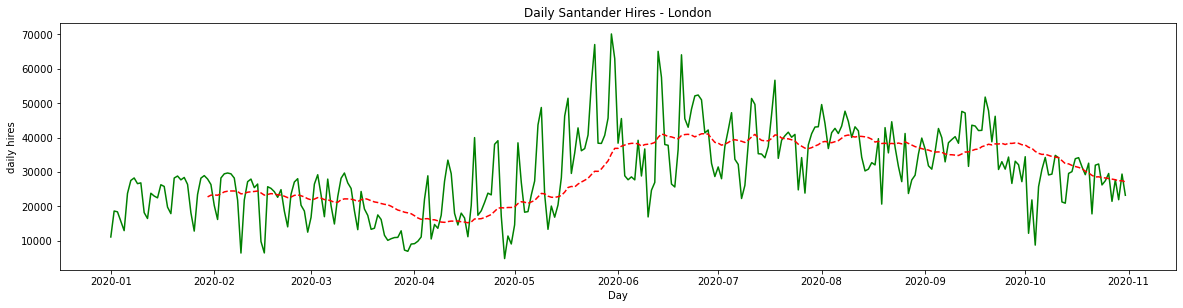

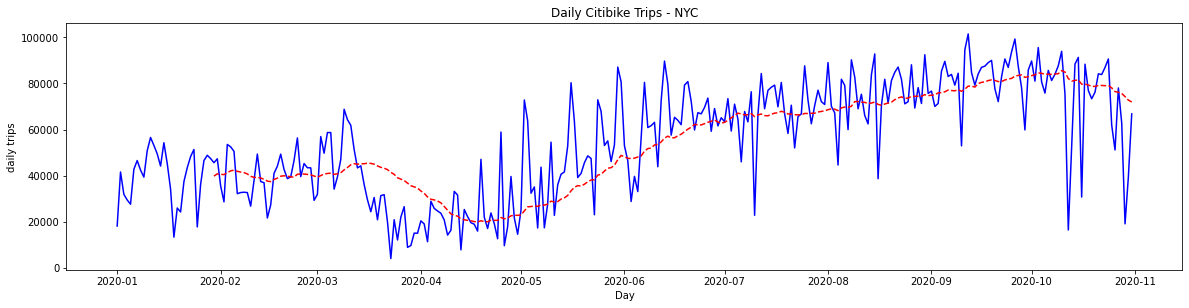

In [31]:
# plot London and NYC daily cycling over time
# the '--' line is 30-day moving average
xTime = compare_cycling['Day']
yLondon = compare_cycling['daily_hires_london']
yNYC = compare_cycling['daily_cycling_nyc']
plt.figure(figsize = (20,10))
plt.subplot(211)
plt.title('Daily Santander Hires - London')
plt.xlabel('Day')
plt.ylabel('daily hires')
London_line = plt.plot(xTime,yLondon, label = 'London', color = 'green')
London_mean_line = plt.plot(xTime,yLondon.rolling(window = 30).mean(), linestyle='--',color='red')


plt.figure(figsize = (20,10))
plt.subplot(212)
plt.title('Daily Citibike Trips - NYC')
plt.xlabel('Day')
plt.ylabel('daily trips')
yellow_data_line = plt.plot(xTime,yNYC, label = 'NYC', color = 'blue')
yellow_mean_line = plt.plot(xTime,yNYC.rolling(window = 30).mean(),linestyle='--',color='red')
plt.show()

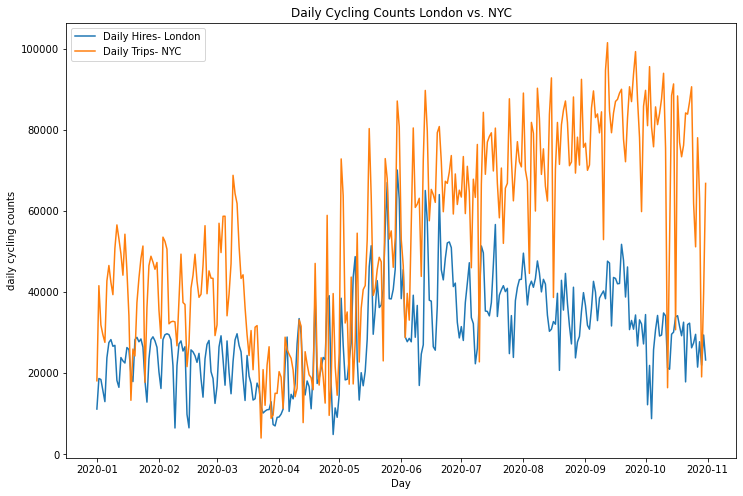

In [32]:
#plot both on same graph to compare
fig, ax = plt.subplots(1,1, figsize = (12,8))
plt.plot(compare_cycling.Day,compare_cycling.daily_hires_london, label='Daily Hires- London')
plt.plot(compare_cycling.Day,compare_cycling.daily_cycling_nyc, label='Daily Trips- NYC')
plt.title('Daily Cycling Counts London vs. NYC')
plt.xlabel('Day')
plt.ylabel('daily cycling counts')
plt.legend()